In [1]:
from timeseria import logger
logger.setup(level='INFO')

# Temperature and humidity forecasting with LSTM


This notebook showcase the periodic average forecatser of [Timeseria](https://github.com/sarusso/Timeseria).

This forecaster is very simple (yet somehow powerful) but most importanlty it fits nearly instantaneously and it has the very same interfaces as its more powerful counterparts as the neural network-based ones.

It is a very useful "toy forecaster" to get used with a number of things including data windowing and model accuracy evaluation.

In [2]:
from timeseria import  storages

# Set sataset path to Timeria test CSV data
DATASET_PATH = '/'.join(storages.__file__.split('/')[0:-1]) + '/tests/test_data/csv/'

# Create a CSV storage pointing to a temperature and humidity dataset
csv_storage = storages.CSVFileStorage(DATASET_PATH + 'humitemp_long.csv')

# Get the time series out from the CSV file storage
timeseries = csv_storage.get()

In [3]:
# Have a look at the time series
timeseries

Time series of #17910 points at variable resolution (~615s), from point @ 1546475294.0 (2019-01-03 00:28:14+00:00) to point @ 1557964581.0 (2019-05-15 23:56:21+00:00)

[INFO] timeseria.plots: Aggregating by "10" for improved plotting


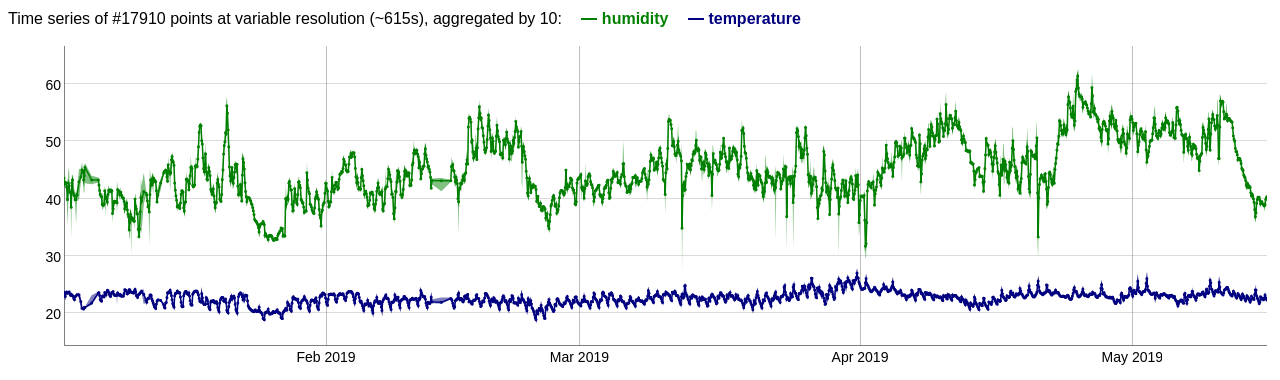

In [4]:
# Plot the time series
timeseries.plot()

In [5]:
# Resample to one hour, and make data uniform
timeseries = timeseries.resample('1h')

[INFO] timeseria.transformations: Using auto-detected sampling interval: 615.0s
[INFO] timeseria.transformations: Resampled 17910 DataTimePoints in 3191 DataTimePoints


## Model fit, usage and evaluation

In [6]:
from timeseria.models import LSTMForecaster

# Instantiate and fit the model
forecaster = LSTMForecaster(window=24, neurons=256, features=['values', 'diffs', 'hours'])
forecaster.fit(timeseries, epochs=5, verbose=True)

Epoch 1/5
99/99 [==============================] - 12s 97ms/step - loss: 0.0098
Epoch 2/5
99/99 [==============================] - 9s 88ms/step - loss: 0.0022
Epoch 3/5
99/99 [==============================] - 8s 85ms/step - loss: 0.0018
Epoch 4/5
99/99 [==============================] - 8s 82ms/step - loss: 0.0017
Epoch 5/5
99/99 [==============================] - 8s 84ms/step - loss: 0.0017


In [7]:
# Call the predict() function of the model. This returns key-value data with the prediction values
forecaster.predict(timeseries)

{'humidity': 40.35022222914424, 'temperature': 22.02573014886128}

In [8]:
# The timeseries on which to call the predict has to be at least of 24 hours (the window length)
try:
    forecaster.predict(timeseries[0:23])
except Exception as e:
    print(e)

The timeseries length (23) is shorter than the model window (24), it must be at least equal.


In [9]:
# The forecats() method returns not only data but also their data points, with the timestamp
forecaster.forecast(timeseries)

DataTimePoint @ 1557964800.0 (2019-05-16 00:00:00+00:00) with data "{'humidity': 40.35022222914424, 'temperature': 22.02573014886128}"

In [10]:
# The apply() method allows instead to directly apply the model on a time series
# (by combining the forecasts with the real observations).
timeseries_with_forecast = forecaster.apply(timeseries, steps=24)

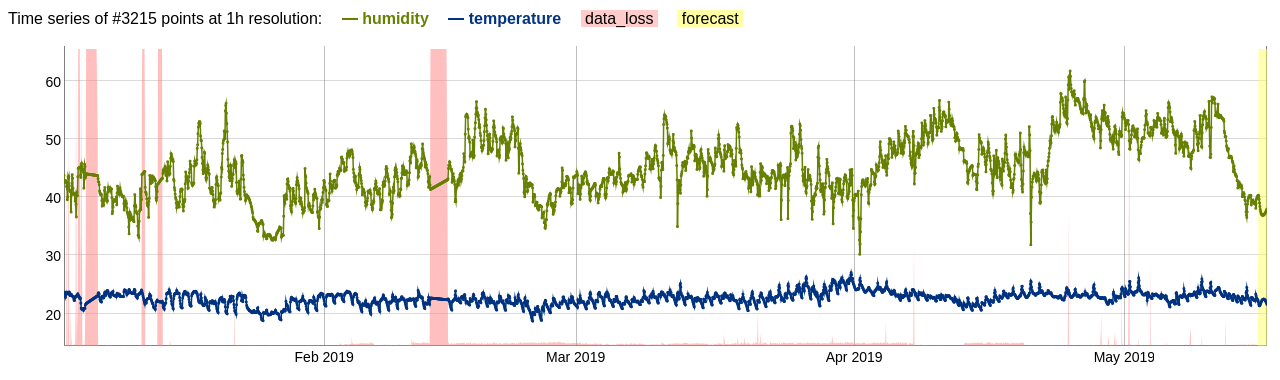

In [11]:
# Plot the time series together with the prediction
timeseries_with_forecast.plot()